In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense, BatchNormalization, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [17]:
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.16.1
GPU Available:  []
Num GPUs Available:  0


In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

## 1. Data Normalization

In [19]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
# Load and prepare data
data = pd.read_csv('data/data_20percent.csv') # path to your downloaded dataset or filtred by resize.ipynb
encoder = LabelEncoder()
data['source_encoded'] = encoder.fit_transform(data['source'])
data.head()

,text,source,prompt_id,text_length,word_count,source_encoded
0,Woohoo! Best Cirque show I've been to yet! Som...,Bloom-7B,0,756,141,0
1,The immune system is a system of many biologic...,Bloom-7B,0,5513,715,0
2,My proposition is that pronouns past the three...,Bloom-7B,0,1169,200,0
3,I used to go to church all the time. My life w...,Bloom-7B,0,911,168,0
4,"Mark McCarroll, a father-of-one, was working a...",Bloom-7B,0,366,66,0


In [21]:
# distribution of sources
data['source'].value_counts()

source
Human                       69538
GPT-3.5                     10469
Text-Davinci-003             4572
Text-Davinci-002             4287
OPT-1.3B                     3693
                            ...  
Toppy-M-7B                     87
LLaMA-2-7B                     82
Dolphin-Mixtral-8x7B           81
Cohere-Command                 78
Dolphin-2.5-Mixtral-8x7B       46
Name: count, Length: 63, dtype: int64

In [22]:
# Split dataset into training and validation sets
train_data, validate_data = train_test_split(data, test_size=0.05, random_state=42)

In [23]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['text'])
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
validate_sequences = tokenizer.texts_to_sequences(validate_data['text'])

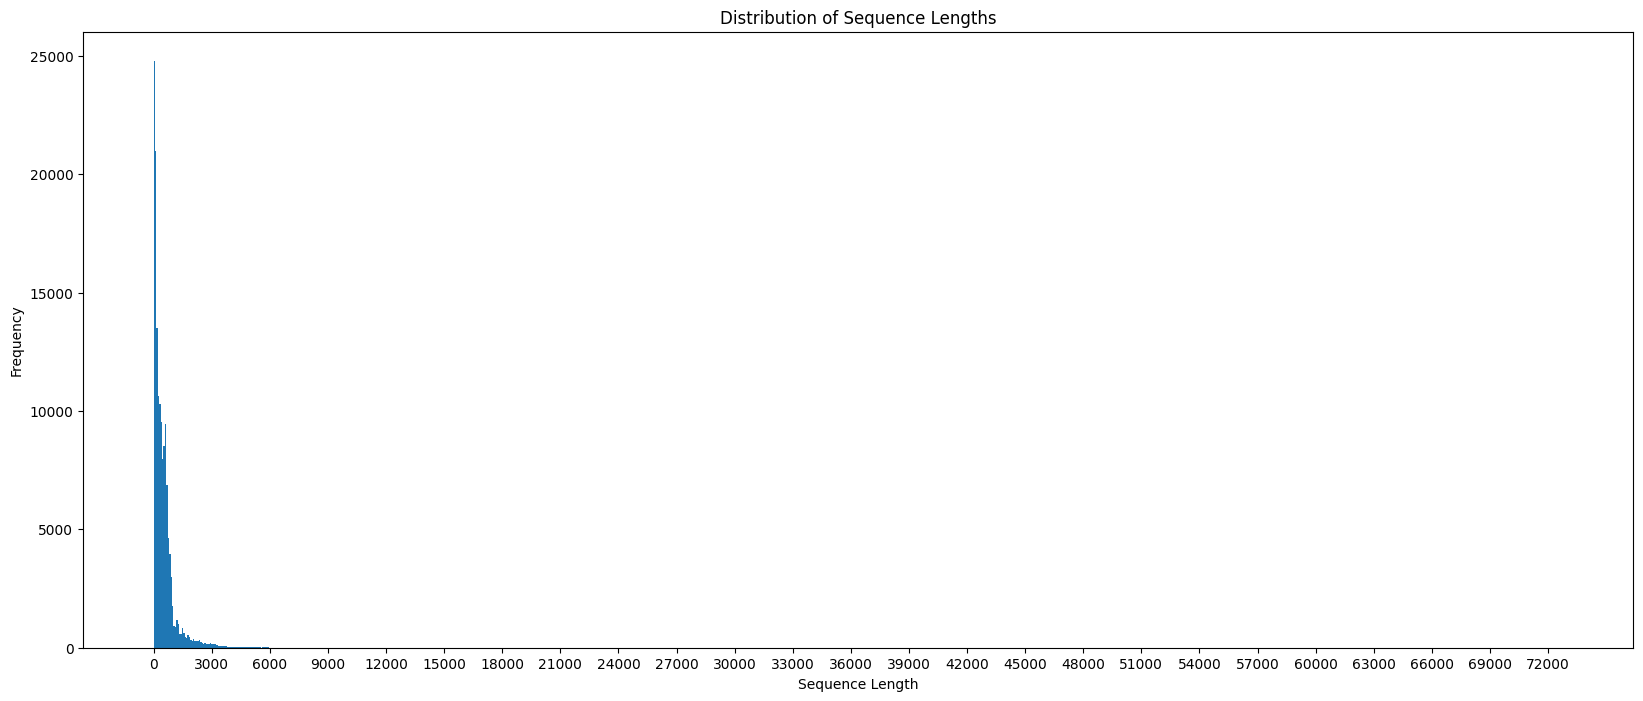

In [24]:
# Analyze the distribution of sequence lengths
sequence_lengths = [len(x) for x in train_sequences]
plt.figure(figsize=(20, 8))
plt.hist(sequence_lengths, bins=1000)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.xticks(range(min(sequence_lengths), max(sequence_lengths) + 1, 3000))
plt.show()

In [25]:
# Pad sequences to ensure uniform length
max_length = 100
num_of_classes = 63
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
validate_padded = pad_sequences(validate_sequences, maxlen=max_length, padding='post', truncating='post')

In [26]:
# Prepare labels
train_labels = train_data['source_encoded'].values
validate_labels = validate_data['source_encoded'].values

## 2. RNN architectures

In [27]:
# Classic models
model_1 = Sequential([
    Embedding(10000, 64, input_length=max_length),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(64),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])

model_2 = Sequential([
    Embedding(10000, 64, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])

model_3 = Sequential([
    Embedding(10000, 64, input_length=max_length),
    GRU(64, return_sequences=True),
    GRU(64),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])

c:\Users\alexe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
# Custom ones
model_4 = Sequential([
    Embedding(10000, 128, input_length=max_length),
    SimpleRNN(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    SimpleRNN(128),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(num_of_classes, activation='softmax')
])

model_5 = Sequential([
    Embedding(10000, 128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(128)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(num_of_classes, activation='softmax')
])

model_6 = Sequential([
    Embedding(10000, 128, input_length=max_length),
    Bidirectional(GRU(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    Bidirectional(GRU(128)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(num_of_classes, activation='softmax')
])

In [29]:
# Compile all models
histories = {}
models = [model_1, model_2, model_3, model_4, model_5, model_6]
for model in models:
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 3. Model Training

In [30]:
print(f"Training Classic SimpleRNN")
history = model_1.fit(train_padded, train_labels, epochs=10, validation_data=(validate_padded, validate_labels), verbose=1)
histories[f'history_1'] = history

Training Classic SimpleRNN
Epoch 1/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 91s 19ms/step - accuracy: 0.4369 - loss: 2.5960 - val_accuracy: 0.4644 - val_loss: 2.4129
Epoch 2/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 89s 19ms/step - accuracy: 0.4548 - loss: 2.4048 - val_accuracy: 0.4553 - val_loss: 2.4589
Epoch 3/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 89s 19ms/step - accuracy: 0.4536 - loss: 2.4235 - val_accuracy: 0.4629 - val_loss: 2.3989
Epoch 4/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 89s 19ms/step - accuracy: 0.4576 - loss: 2.3820 - val_accuracy: 0.4458 - val_loss: 2.4012
Epoch 5/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 89s 19ms/step - accuracy: 0.4566 - loss: 2.3545 - val_accuracy: 0.4531 - val_loss: 2.3933
Epoch 6/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 89s 19ms/step - accuracy: 0.4537 - loss: 2.3747 - val_accuracy: 0.4681 - val_loss: 2.3425
Epoch 7/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 90s 19ms/step - accuracy: 0.4620 - loss: 2.3355 - val_accuracy: 0.4570 - val_loss: 2.3701
Epoch 8/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 89s 19m

In [31]:
print(f"Training Classic LSTM")
history = model_2.fit(train_padded, train_labels, epochs=10, validation_data=(validate_padded, validate_labels), verbose=1)
histories[f'history_2'] = history

Training Classic LSTM
Epoch 1/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 239s 51ms/step - accuracy: 0.4424 - loss: 2.4846 - val_accuracy: 0.4951 - val_loss: 1.9262
Epoch 2/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 230s 49ms/step - accuracy: 0.4987 - loss: 1.8425 - val_accuracy: 0.5241 - val_loss: 1.6951
Epoch 3/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 228s 49ms/step - accuracy: 0.5325 - loss: 1.6099 - val_accuracy: 0.5452 - val_loss: 1.5614
Epoch 4/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 230s 49ms/step - accuracy: 0.5662 - loss: 1.4440 - val_accuracy: 0.5511 - val_loss: 1.5188
Epoch 5/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 228s 49ms/step - accuracy: 0.5930 - loss: 1.3193 - val_accuracy: 0.5517 - val_loss: 1.5338
Epoch 6/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 228s 49ms/step - accuracy: 0.6177 - loss: 1.2206 - val_accuracy: 0.5490 - val_loss: 1.5796
Epoch 7/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 228s 49ms/step - accuracy: 0.6386 - loss: 1.1341 - val_accuracy: 0.5513 - val_loss: 1.6356
Epoch 8/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 228s 

In [32]:
print(f"Training Classic GRU")
history = model_3.fit(train_padded, train_labels, epochs=10, validation_data=(validate_padded, validate_labels), verbose=1)
histories[f'history_3'] = history

Training Classic GRU
Epoch 1/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 230s 48ms/step - accuracy: 0.4746 - loss: 2.1981 - val_accuracy: 0.5283 - val_loss: 1.6753
Epoch 2/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 226s 48ms/step - accuracy: 0.5368 - loss: 1.6001 - val_accuracy: 0.5518 - val_loss: 1.5376
Epoch 3/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 226s 48ms/step - accuracy: 0.5721 - loss: 1.4251 - val_accuracy: 0.5599 - val_loss: 1.5115
Epoch 4/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 227s 48ms/step - accuracy: 0.5998 - loss: 1.3025 - val_accuracy: 0.5592 - val_loss: 1.5181
Epoch 5/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 226s 48ms/step - accuracy: 0.6254 - loss: 1.1957 - val_accuracy: 0.5606 - val_loss: 1.5504
Epoch 6/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 226s 48ms/step - accuracy: 0.6476 - loss: 1.0988 - val_accuracy: 0.5578 - val_loss: 1.6229
Epoch 7/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 226s 48ms/step - accuracy: 0.6719 - loss: 1.0124 - val_accuracy: 0.5560 - val_loss: 1.7230
Epoch 8/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 227s 4

In [33]:
print(f"Training Custom SimpleRNN")
history = model_4.fit(train_padded, train_labels, epochs=10, validation_data=(validate_padded, validate_labels), verbose=1)
histories[f'history_4'] = history

Training Custom SimpleRNN
Epoch 1/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 141s 30ms/step - accuracy: 0.4265 - loss: 2.7217 - val_accuracy: 0.4412 - val_loss: 2.8473
Epoch 2/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - accuracy: 0.4379 - loss: 2.5962 - val_accuracy: 0.4412 - val_loss: 2.5584
Epoch 3/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - accuracy: 0.4375 - loss: 2.5633 - val_accuracy: 0.4412 - val_loss: 2.4803
Epoch 4/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - accuracy: 0.4412 - loss: 2.4855 - val_accuracy: 0.4412 - val_loss: 2.4403
Epoch 5/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - accuracy: 0.4405 - loss: 2.4758 - val_accuracy: 0.4414 - val_loss: 2.4568
Epoch 6/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - accuracy: 0.4405 - loss: 2.4772 - val_accuracy: 0.4478 - val_loss: 2.4800
Epoch 7/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - accuracy: 0.4399 - loss: 2.4953 - val_accuracy: 0.4412 - val_loss: 2.5067
Epoch 8/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 1

In [34]:
print(f"Training Custom LSTM")
history = model_5.fit(train_padded, train_labels, epochs=10, validation_data=(validate_padded, validate_labels), verbose=1)
histories[f'history_5'] = history

Training Custom LSTM
Epoch 1/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 500s 106ms/step - accuracy: 0.4841 - loss: 2.0468 - val_accuracy: 0.5281 - val_loss: 1.6821
Epoch 2/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 492s 105ms/step - accuracy: 0.5521 - loss: 1.5579 - val_accuracy: 0.5605 - val_loss: 1.5165
Epoch 3/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 492s 105ms/step - accuracy: 0.5833 - loss: 1.3977 - val_accuracy: 0.5749 - val_loss: 1.4988
Epoch 4/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 494s 106ms/step - accuracy: 0.6052 - loss: 1.2856 - val_accuracy: 0.5748 - val_loss: 1.4503
Epoch 5/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 495s 106ms/step - accuracy: 0.6266 - loss: 1.1890 - val_accuracy: 0.5688 - val_loss: 1.4860
Epoch 6/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 497s 106ms/step - accuracy: 0.6455 - loss: 1.1053 - val_accuracy: 0.5739 - val_loss: 1.5161
Epoch 7/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 497s 106ms/step - accuracy: 0.6618 - loss: 1.0386 - val_accuracy: 0.5582 - val_loss: 1.5932
Epoch 8/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━

In [35]:
print(f"Training Custom GRU")
history = model_6.fit(train_padded, train_labels, epochs=10, validation_data=(validate_padded, validate_labels), verbose=1)
histories[f'history_6'] = history

Training Custom GRU
Epoch 1/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 517s 109ms/step - accuracy: 0.4892 - loss: 2.0329 - val_accuracy: 0.5629 - val_loss: 1.5254
Epoch 2/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 507s 108ms/step - accuracy: 0.5693 - loss: 1.4673 - val_accuracy: 0.5657 - val_loss: 1.4569
Epoch 3/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 509s 109ms/step - accuracy: 0.6022 - loss: 1.3028 - val_accuracy: 0.5838 - val_loss: 1.4218
Epoch 4/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 513s 110ms/step - accuracy: 0.6307 - loss: 1.1796 - val_accuracy: 0.5913 - val_loss: 1.4626
Epoch 5/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 522s 111ms/step - accuracy: 0.6556 - loss: 1.0764 - val_accuracy: 0.5757 - val_loss: 1.5190
Epoch 6/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 525s 112ms/step - accuracy: 0.6772 - loss: 0.9856 - val_accuracy: 0.5669 - val_loss: 1.6141
Epoch 7/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 528s 113ms/step - accuracy: 0.6994 - loss: 0.9093 - val_accuracy: 0.5701 - val_loss: 1.7058
Epoch 8/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 

# 4. Plotting

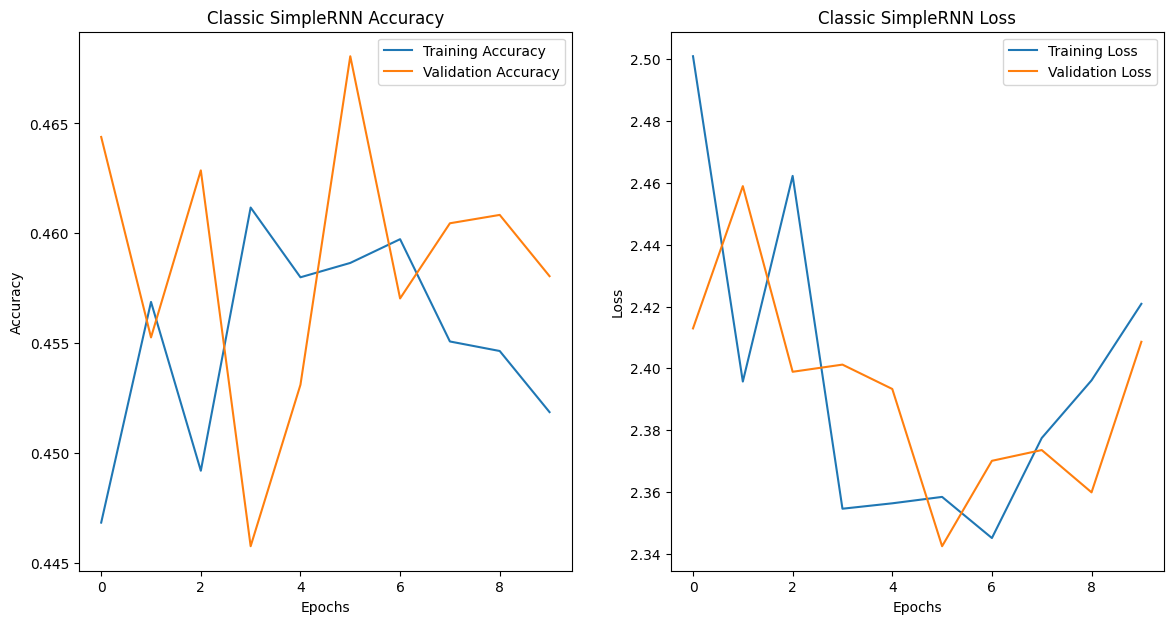

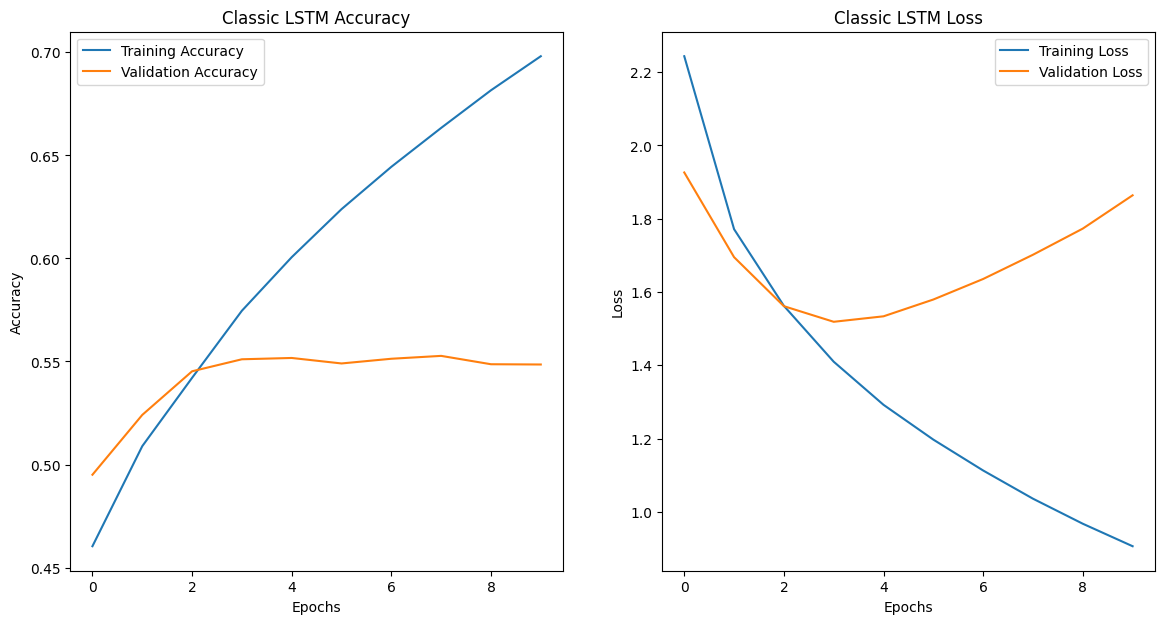

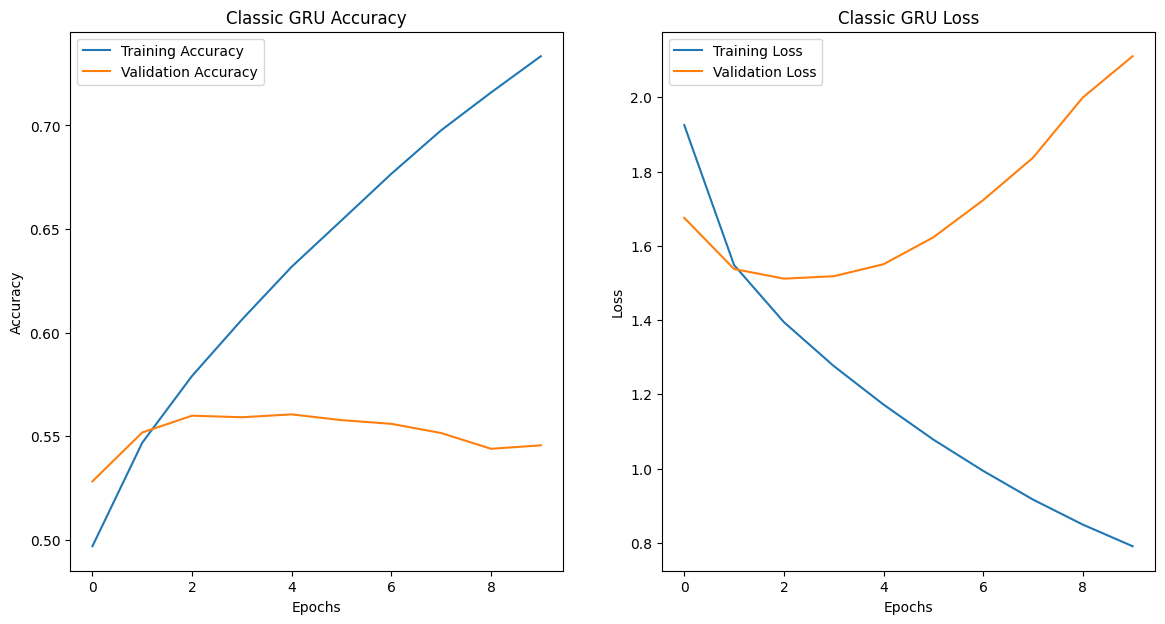

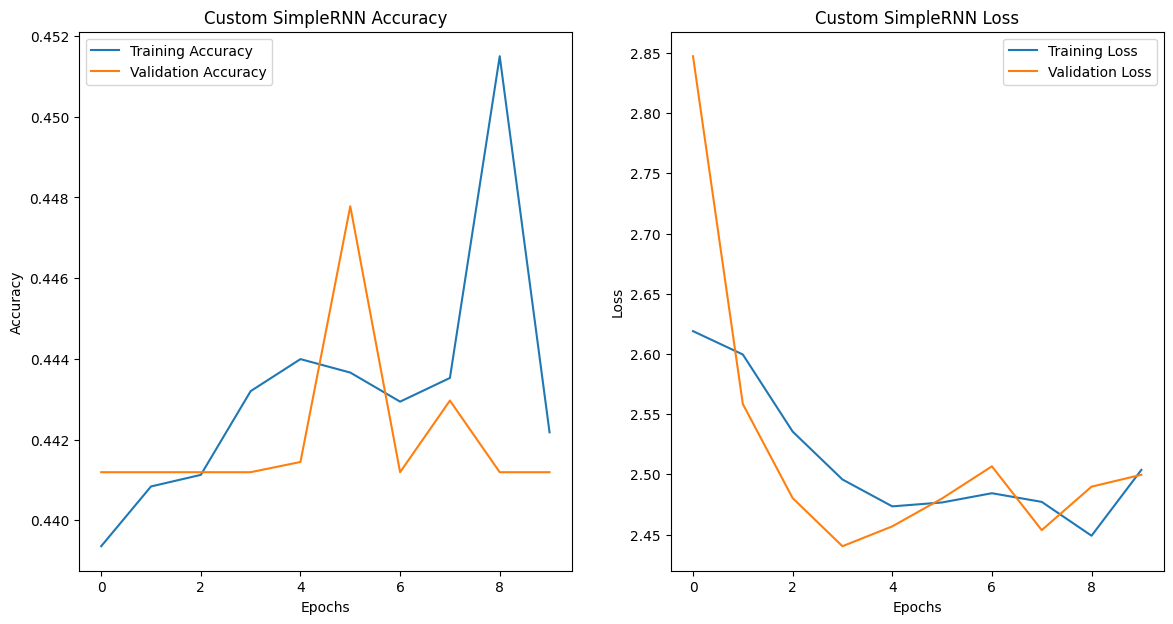

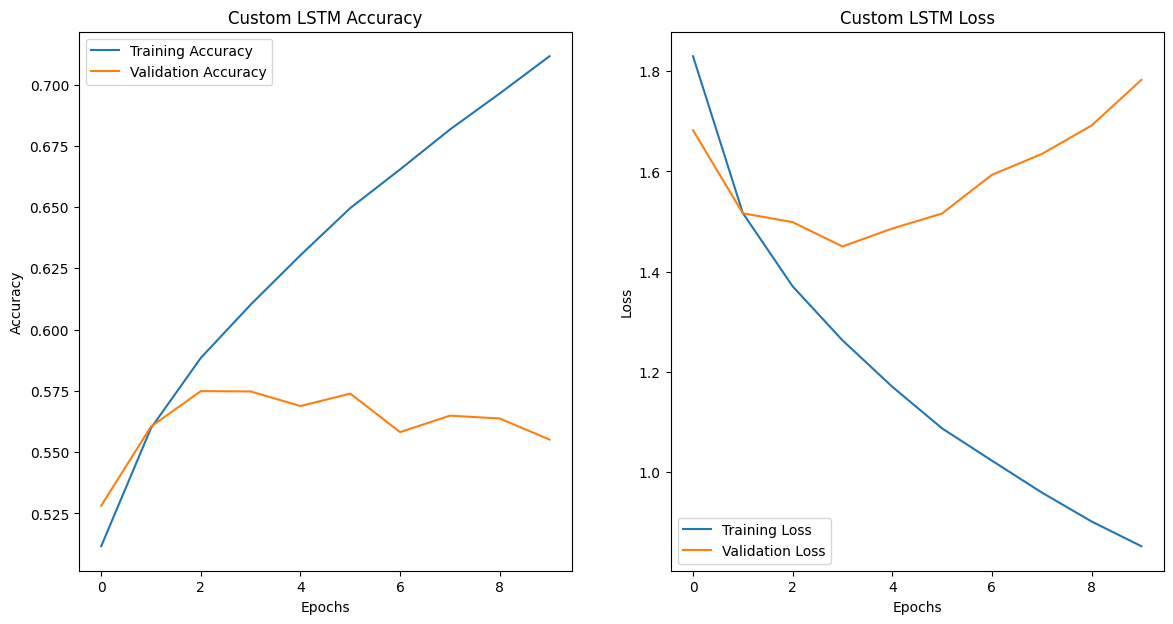

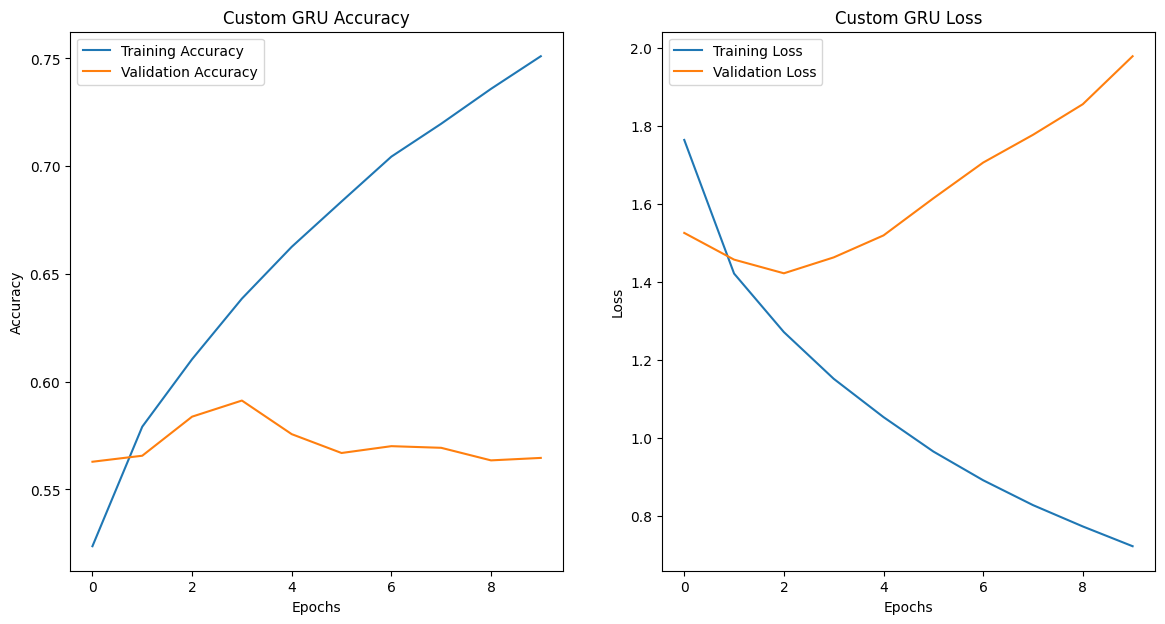

In [44]:
# Names for clarity in the loop
model_names = ["Classic SimpleRNN", "Classic LSTM", "Classic GRU", "Custom SimpleRNN", "Custom LSTM", "Custom GRU"]

# Assuming models and histories are populated as in your provided code snippet
for i, model in enumerate(models, 1):
    history_key = f'history_{i}'
    history = histories[history_key]
    
    # Plot accuracy and loss graphs
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_names[i-1]} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_names[i-1]} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


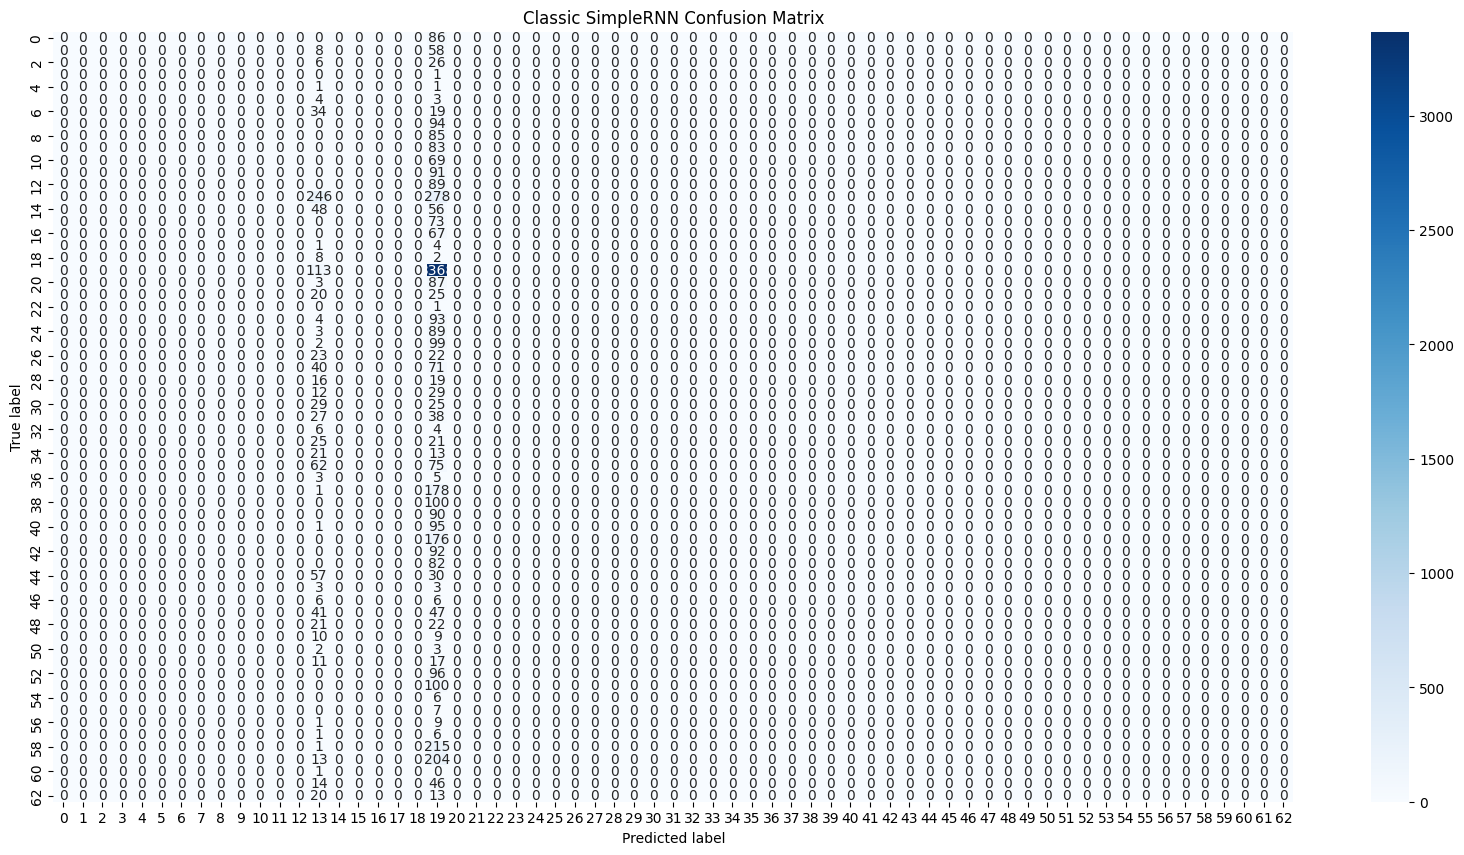

247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


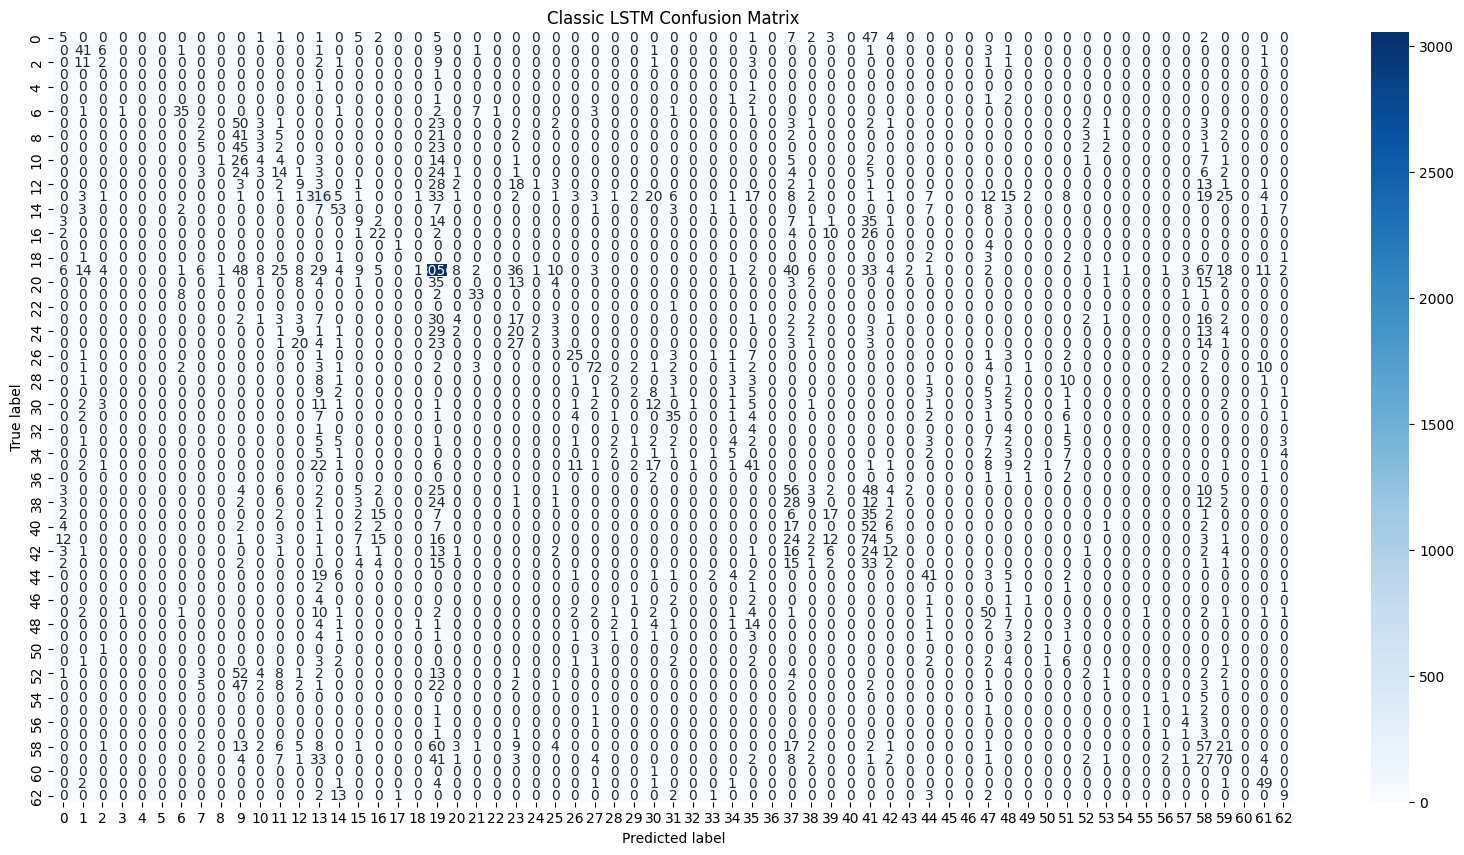

247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


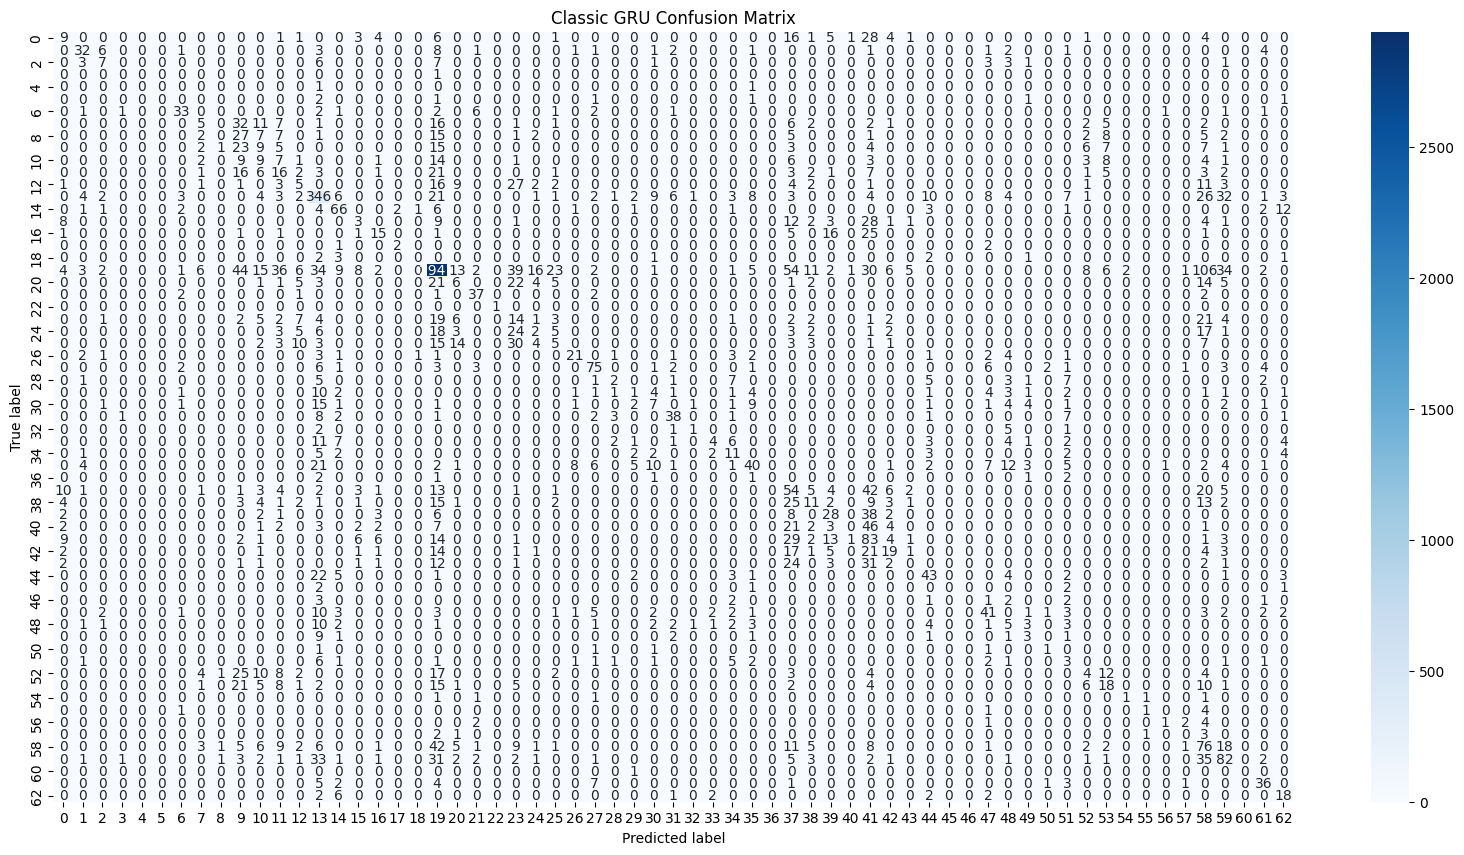

247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


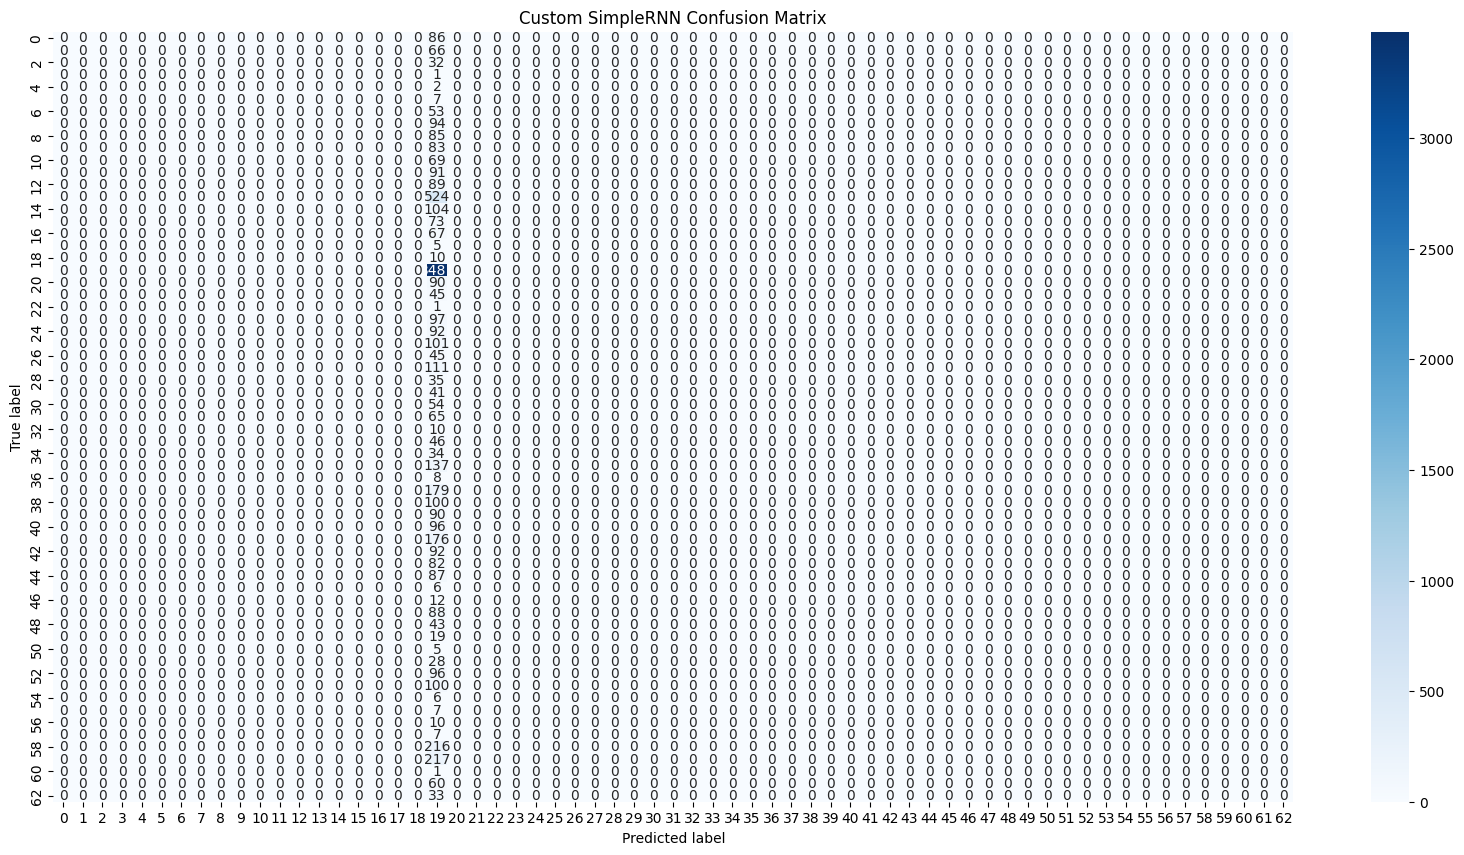

247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step


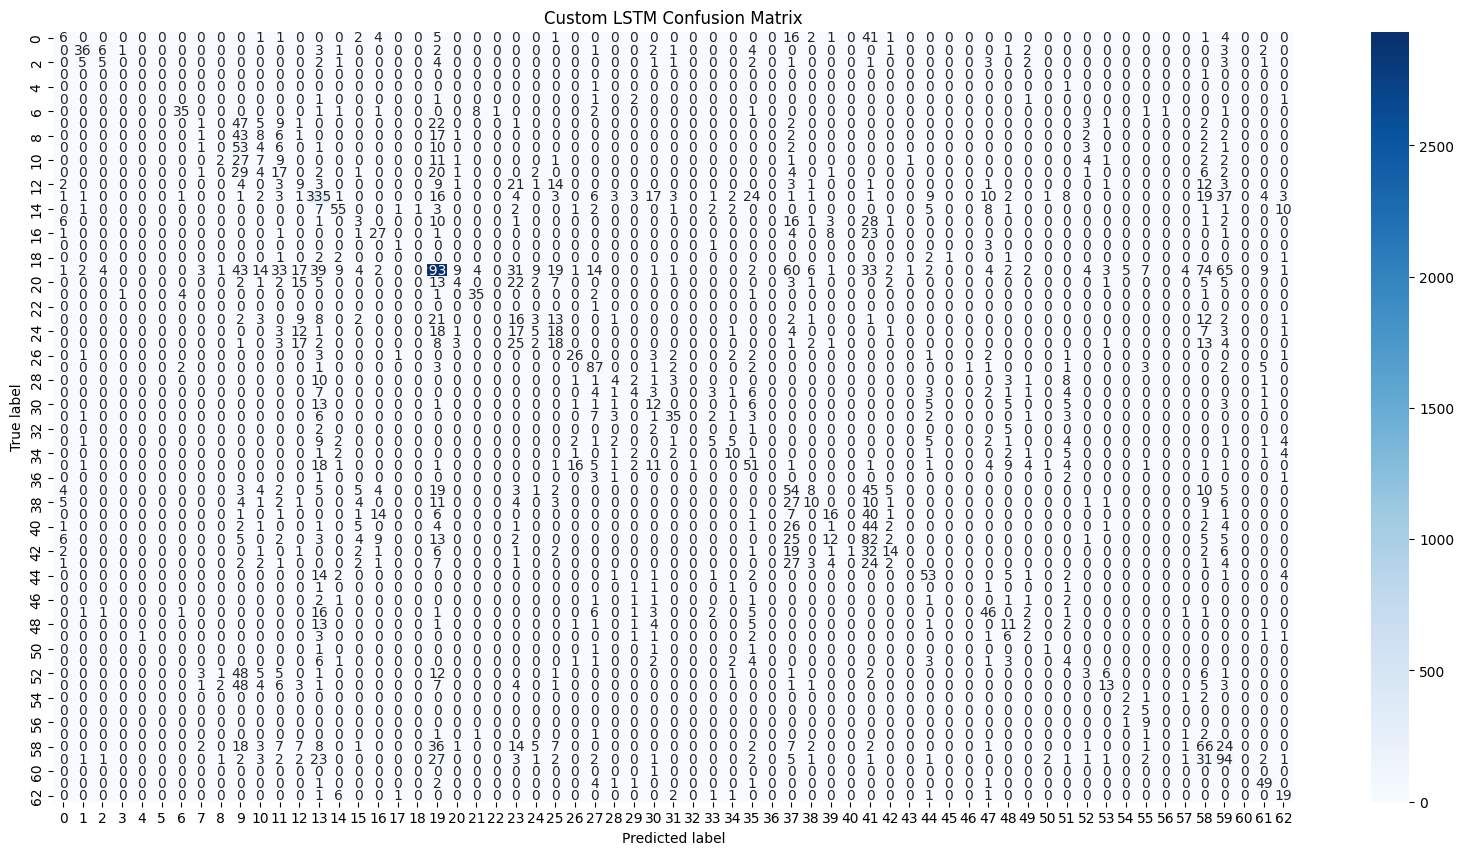

247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step


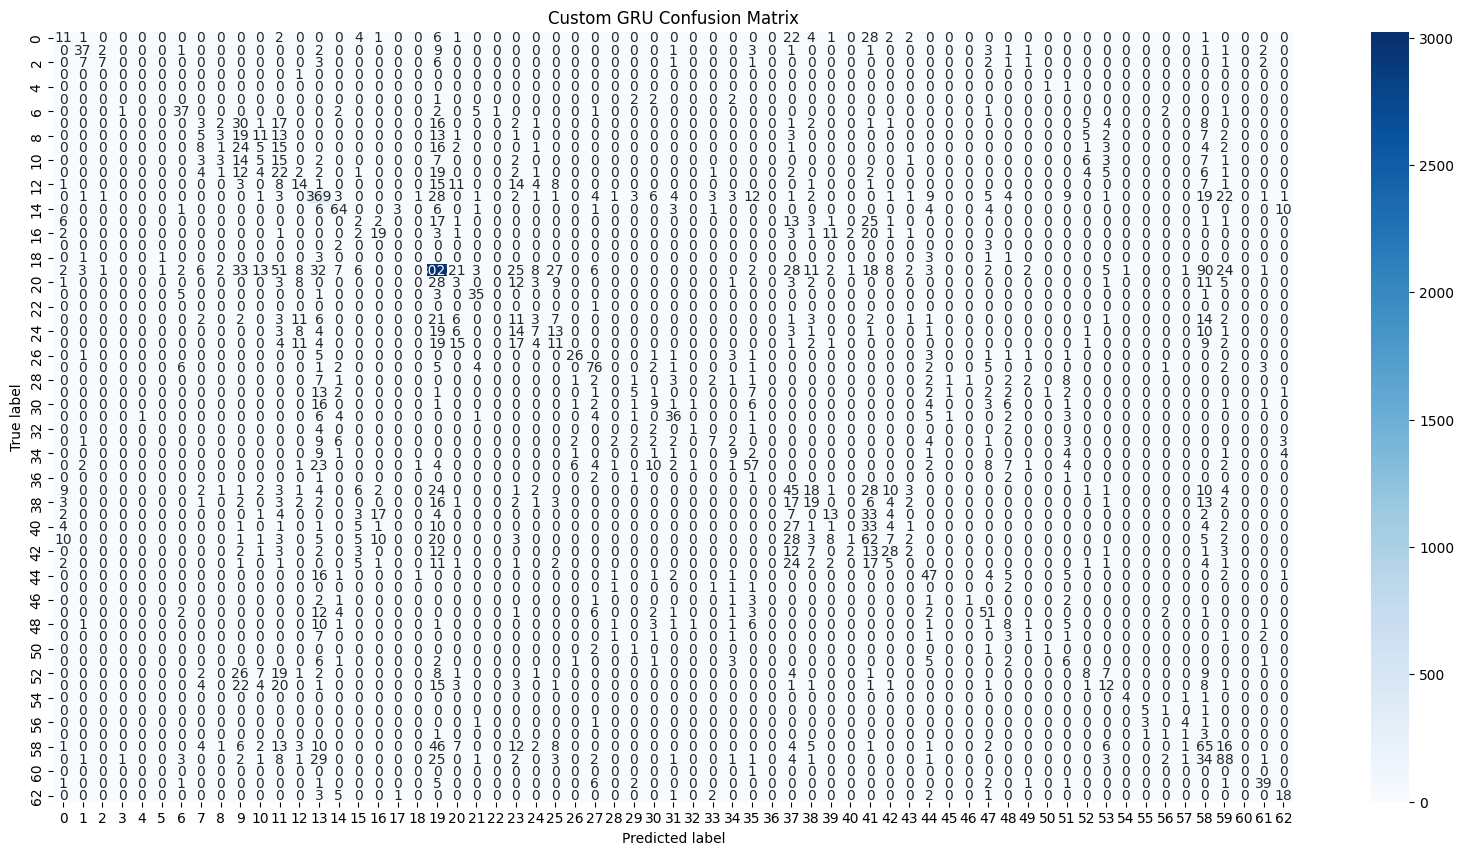

In [46]:
for i, model in enumerate(models, 1):
    # Plot confusion matrix
    predictions = model.predict(validate_padded)
    cm = confusion_matrix(validate_labels, np.argmax(predictions, axis=1))
    plt.figure(figsize=(20, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_names[i-1]} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()